**Deep Learning - UTS Nomor 2**

**Nama: Janice Ashley Kurniawan**

**NIM: 2602203794**

In [ ]:
# importing libraries

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, RandomFlip, RandomRotation, Rescaling

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 2A

In [ ]:
DATASET_PATH = "../dataset/Dataset2B/"

# resize resolusi gambar menjadi 224 x 224

image_size = (224, 224)
batch_size = 16

# pisahkan dataset menjadi 80% training set, 10% validation set, dan 10% test set

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH),
    validation_split=0.2,
    label_mode = "categorical",
    subset="training",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH),
    validation_split=0.1,
    label_mode = "categorical",
    subset="validation",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH),
    validation_split=0.1,
    label_mode = "categorical",
    subset="test",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1600 files belonging to 4 classes.
Using 1280 files for training.
Found 1600 files belonging to 4 classes.
Using 160 files for validation.
Found 1600 files belonging to 4 classes.
Using 160 files for validation.


### EDA

In [ ]:
train_ds.class_names

['banana', 'betel_nut', 'bitter_gourd', 'black_berry']

Found 1600 files belonging to 4 classes.
Using 160 files for training.
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


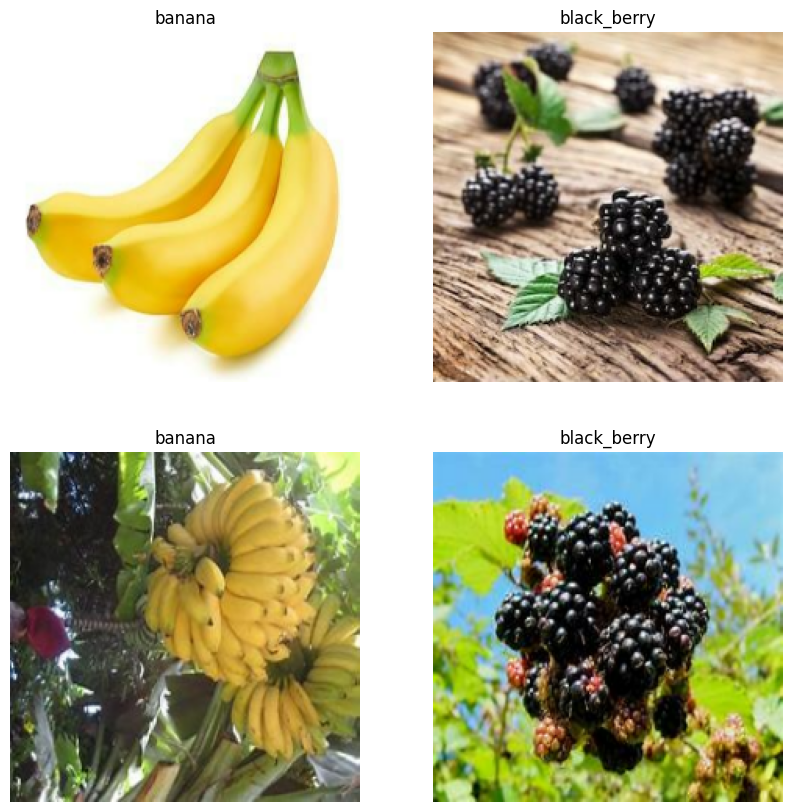

In [ ]:
get_sample = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH),
    validation_split=0.9,
    label_mode = "categorical",
    subset="training",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=4,
)

plt.figure(figsize=(10, 10))
for images, labels in get_sample.take(1):
    for i in range(len(images)):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(labels[i])
        plt.title(train_ds.class_names[int(np.argmax(labels[i].numpy()).astype("uint8"))])
        plt.axis("off")

plt.show()

Image: 997.jpg


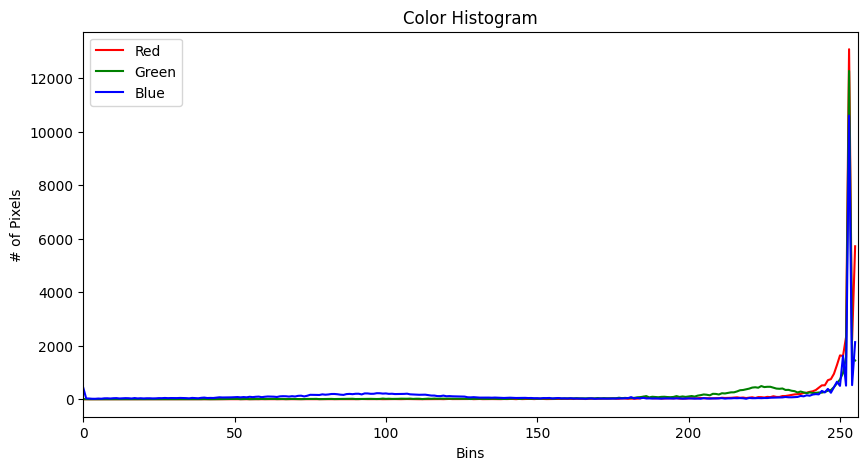

In [ ]:
# histogram warna untuk salah satu image yang diambil secara random dari folder banana

def plot_color_histogram(image_path):
    image = cv2.imread(image_path)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0,256])
    hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0,256])
    hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0,256])

    plt.figure(figsize=(10, 5))
    plt.title('Color Histogram')
    plt.xlabel('Bins')
    plt.ylabel('# of Pixels')
    plt.plot(hist_r, color='red', label='Red')
    plt.plot(hist_g, color='green', label='Green')
    plt.plot(hist_b, color='blue', label='Blue')
    plt.legend()
    plt.xlim([0, 256])
    plt.show()

folder_path = "../dataset/Dataset2B/banana/"
image_files = os.listdir(folder_path)
image_filename = random.choice(image_files)
image_path = os.path.join(folder_path, image_filename)
print("Image:", image_filename)
plot_color_histogram(image_path)

In [ ]:
# hitung average noise dari semua image dalam dataset

def average_noise(folder):
    total_noise = 0
    num_images = 0

    for folder_name in os.listdir(folder):
        folder_path = os.path.join(folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)
                image = cv2.imread(image_path)
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray_image, cv2.CV_64F).var()
                total_noise += variance
                num_images += 1
    average_noise = total_noise / num_images
    print("Average noise:", average_noise)
average_noise(DATASET_PATH)

Average noise: 3076.3680426070587


# 2B

## Tantangan dan Kesulitan:

### Image Quality (Resolution, Noise)
-> image pada dataset ini memiliki resolusi yang berbeda-beda, sehingga dapat mengakibatkan ketidak konsistenan dalam analisis. maka dari itu, untuk mengatasi hal ini, kita harus meresize image resolutionnya agar seragam (224 x 224). image pada dataset ini juga memiliki noise yang cukup tinggi, yaitu 3076. selain itu, datanya masih banyak yang tidak full gambar yang ingin diklasifikasi, sehingga ada banyak warna-warna yang dapat mengganggu proses training dari model kita.


### Image Variability (Lightning Conditions, Perspective and Angle, Occlusions, Background Variability, Scale Variations)
-> image pada dataset ini memiliki image variability yang cukup banyak dilihat dari lightning conditions, perspective and angle, occlusions, background variability, scale variations, dan jenis variasi lainnya yang mempengaruhi tampilan dari objek dalam gambar. dengan demikian, model akan belajar untuk mengenali objek-objek dalam berbagai kondisi, dan menjadi lebih robust terhadap variasi gambar yang ditemui.

*contoh image quality dan image variability dapat dilihat dari ouput codingan di bagian 2A*

# 2C

### First Model, Arsitektur Baseline VGG-16

Model pretrained VGG-16 adalah model CNN yang telah ditrain sebelumnya pada dataset besar seperti ImageNet. VGG-16 terdiri dari 16 layer, yang terdiri dari convolution layer, max pooling layer, dan beberapa dense layer di bagian akhir.

Metode fine-tuning melibatkan penggunaan arsitektur yang sudah ada (VGG-16) dan melatihnya kembali pada dataset yang lebih kecil atau spesifik untuk tugas tertentu. Proses ini membantu model untuk menyesuaikan dengan dataset yang baru dan memperbaiki kinerja pada tugas yang diinginkan.

In [ ]:
CLASS_AMOUNT = 4
INPUT_SHAPE = (224,224,3)

In [ ]:
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

base_model = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(inputs)
base_model = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

X = Flatten()(base_model)
# X = GlobalAveragePooling2D()(base_model)

X = Dense(units=4096,activation='relu')(X)
X = Dense(units=4096,activation='relu')(X)
outputs = Dense(units=CLASS_AMOUNT,activation='softmax')(X)

In [ ]:
FIRST_MODEL = Model(inputs,outputs)
FIRST_MODEL.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

In [ ]:
FIRST_MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=['accuracy'])

In [ ]:
FIRST_MODEL.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
80/80 [==============================] - 303s 4s/step - loss: 103.5338 - accuracy: 0.2422 - val_loss: 1.3859 - val_accuracy: 0.2313
Epoch 2/10
80/80 [==============================] - 305s 4s/step - loss: 1.4942 - accuracy: 0.2188 - val_loss: 1.3796 - val_accuracy: 0.2688
Epoch 3/10
80/80 [==============================] - 300s 4s/step - loss: 1.6615 - accuracy: 0.2328 - val_loss: 1.3862 - val_accuracy: 0.2750
Epoch 4/10
80/80 [==============================] - 304s 4s/step - loss: 1.9741 - accuracy: 0.2391 - val_loss: 1.3841 - val_accuracy: 0.2688
Epoch 4: early stopping


In [ ]:
FIRST_MODEL.evaluate(test_ds)

10/10 [==============================] - 7s 699ms/step - loss: 1.3841 - accuracy: 0.2688


[1.3840863704681396, 0.26875001192092896]

# 2D

### Second Model, Modifikasi Arsitektur VGG 16

- melakukan augmentation data (random flip, random rotation, dan rescaling) pada preprocess input untuk meningkatkan variasi dalam training dataset dan membantu mencegah overfitting, meningkatkan generalisasi model, dan membuat model lebih robust terhadap variasi yang mungkin terjadi dalam test data
- mengubah filter sizes untuk menangkap fitur-fitur berbeda dengan skala yang berbeda dalam image
- menambahkan normalization layer (batch normalization) membantu menjaga stabilitas dan kecepatan konvergensi selama training model dengan menormalisasi output dari layer sebelumnya, serta membantu mencegah masalah seperti vanish gradient dan mempercepat proses training
- menambahkan dropout layer (menghapus sebagian unit-neuron dalam sebuah jaringan selama proses training secara acak) untuk mencegah overfitting dengan memaksa jaringan untuk belajar fitur-fitur yang lebih robust dan mengurangi ketergantungan pada unit-neuron tertentu

In [ ]:
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

preprocessed_inputs = tf.keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
preprocessed_inputs = tf.keras.layers.RandomRotation(0.2)(preprocessed_inputs)
preprocessed_inputs = tf.keras.layers.Rescaling(scale=1/127.0, offset=-1)(preprocessed_inputs)

base_model = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(preprocessed_inputs)
base_model = BatchNormalization()(base_model)
base_model = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Dropout(0.25)(base_model)

base_model = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(inputs)
base_model = BatchNormalization()(base_model)
base_model = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Dropout(0.25)(base_model)

base_model = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

base_model = Dropout(0.25)(base_model)

base_model = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(base_model)
base_model = BatchNormalization()(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=(2,2))(base_model)

X = Flatten()(base_model)
# X = GlobalAveragePooling2D()(base_model)

X = Dense(units=4096,activation='relu')(X)
X = Dense(units=4096,activation='relu')(X)
outputs = Dense(units=CLASS_AMOUNT,activation='softmax')(X)

In [ ]:
SECOND_MODEL = Model(inputs,outputs)
SECOND_MODEL.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_11 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 64)      0   

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\layer_utils.py:146: RuntimeWarning: overflow encountered in scalar multiply
  total_memory_size += weight_shape * per_param_size


In [ ]:
SECOND_MODEL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss="categorical_crossentropy",
                     metrics=['accuracy'])

In [ ]:
SECOND_MODEL.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
80/80 [==============================] - 567s 7s/step - loss: 112.6724 - accuracy: 0.5109 - val_loss: 26.4335 - val_accuracy: 0.5437
Epoch 2/10
80/80 [==============================] - 563s 7s/step - loss: 4.3924 - accuracy: 0.6336 - val_loss: 6.9875 - val_accuracy: 0.6062
Epoch 3/10
80/80 [==============================] - 564s 7s/step - loss: 2.9063 - accuracy: 0.6633 - val_loss: 2.0993 - val_accuracy: 0.6562
Epoch 4/10
80/80 [==============================] - 563s 7s/step - loss: 1.6148 - accuracy: 0.7484 - val_loss: 1.4543 - val_accuracy: 0.6750
Epoch 5/10
80/80 [==============================] - 562s 7s/step - loss: 1.0037 - accuracy: 0.7758 - val_loss: 1.3628 - val_accuracy: 0.7063
Epoch 6/10
80/80 [==============================] - 561s 7s/step - loss: 0.8184 - accuracy: 0.8180 - val_loss: 1.4786 - val_accuracy: 0.7688
Epoch 7/10
80/80 [==============================] - 561s 7s/step - loss: 1.7087 - accuracy: 0.7953 - val_loss: 1.6375 - val_accuracy: 0.6812
Epoch 7: e

In [ ]:
SECOND_MODEL.evaluate(test_ds)

10/10 [==============================] - 7s 666ms/step - loss: 1.6375 - accuracy: 0.6812


[1.6374731063842773, 0.6812499761581421]

In [ ]:
SECOND_MODEL.predict(test_ds)

dari hasil evaluasi, model arsitektur yang telah dimodifikasi memiliki loss sebesar 1.6375 dan accuracy sebesar 0.6812 pada test dataset. yang berarti model tersebut memiliki tingkat kesalahan/loss sekitar 1.6375 dan mampu mengklasifikasikan sekitar 68.12% dari test data dengan benar. untuk memprediksi nilai ground truth dengan hasil yang diprediksi oleh model, kita dapat lihat dari SECOND_MODEL.predict(test_ds) untuk mendapatkan nilai prediksi, dan kemudian membandingkannya dengan nilai ground truth untuk mengevaluasi performa model secara lebih mendalam.

# Presentation Video

link video: https://drive.google.com/file/d/1UibVO_UyFqbsfJmn_bcRqBGumaGhSPMj/view?usp=sharing